In [4]:
import os
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme(style="white", context="paper", palette="muted", rc={"font.family": "Times New Roman"})
plt.rcParams['font.family'] = 'Times New Roman'
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.manifold import TSNE

from datasets import SEEDFeatureDataset, SEEDIVFeatureDataset
from models import PMEEG
from sklearn.metrics import confusion_matrix

from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from collections import Counter


# plt.rcParams.update({
#     "font.family": "Times New Roman",
#     "font.size": 9,                # 适用于单栏图的字体大小
#     "axes.titlesize": 9,
#     "axes.labelsize": 9,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "legend.fontsize": 8,
# })

def setup_seed(seed):  ## setup the random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(20)

In [97]:
data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
seed3_x, seed3_y, seed3_g = SEEDFeatureDataset(data_path).data()
seed3_y += 1
seed3_x = seed3_x.reshape(-1, 310)
seed3_t = seed3_g[:, 2]
seed3_s = seed3_g[:, 1]

seed4_path = "E:\\EEG_DataSets\\SEED_IV\\eeg_feature_smooth\\"
seed4_x, seed4_y, seed4_g = SEEDIVFeatureDataset(seed4_path).data()
seed4_x = seed4_x.reshape(-1, 310)
seed4_t = seed4_g[:, 2]
seed4_s = seed4_g[:, 1]

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(seed4_s):
    seed4_x[seed4_s == i] = min_max_scaler.fit_transform(seed4_x[seed4_s == i])

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(seed3_s):
    seed3_x[seed3_s == i] = min_max_scaler.fit_transform(seed3_x[seed3_s == i])

In [98]:
# For SEED session 1 subject 1
seed3_sub1_x = seed3_x[seed3_s == 1]
seed3_sub1_y = seed3_y[seed3_s == 1]
seed3_sub1_t = seed3_t[seed3_s == 1]

# For SEED-IV session 1 subject 5
seed4_sub5_x = seed4_x[seed4_s == 5]
seed4_sub5_y = seed4_y[seed4_s == 5]
seed4_sub5_t = seed4_t[seed4_s == 5]

In [99]:
def t_sne(x):
    tsne = TSNE(n_components=2, random_state=20)
    x_tsne = tsne.fit_transform(x)
    return x_tsne

In [100]:
seed3 = t_sne(seed3_sub1_x)
seed4 = t_sne(seed4_sub5_x)

In [109]:
# Only Positive samples
seed3_y1_x = seed3[seed3_sub1_y == 1]
seed4_y0_x = seed4[seed4_sub5_y == 0]
seed3_y1_t = seed3_sub1_t[seed3_sub1_y == 1]
seed4_y0_t = seed4_sub5_t[seed4_sub5_y == 0]

In [110]:
def sample_indices(data, ratio=0.2, random_state=42):
    np.random.seed(random_state)
    N = len(data)
    sample_size = int(N * ratio)
    sampled_idx = np.random.choice(np.arange(N), sample_size, replace=False)
    return sampled_idx
sampled_idx_seed3_y1 = sample_indices(seed3_y1_x, ratio=0.2, random_state=42)
seed3_y1_x_sample = seed3_y1_x[sampled_idx_seed3_y1]
seed3_y1_t_sample = seed3_y1_t[sampled_idx_seed3_y1]

# 对 seed4 进行 20% 随机采样
# sampled_idx_seed4 = sample_indices(seed4, ratio=0.1, random_state=42)
# seed4_sample = seed4[sampled_idx_seed4]
# seed4_sub5_y_sample = seed4_sub5_y[sampled_idx_seed4]
# seed4_sub5_t_sample = seed4_sub5_t[sampled_idx_seed4]

In [113]:
colors = [    
    "#FF5733",  # 红色
    "#33FF57",  # 绿色
    "#3357FF",  # 蓝色
    "#FFEB33",  # 黄色
    "#FF9F33",  # 橙色
    "#9B33FF",  # 紫色
]

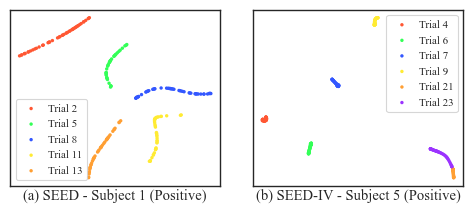

In [283]:
# 推荐的学术论文单栏图设置

fig, axes = plt.subplots(1, 2, figsize=(5, 2.2))
axes = axes.flatten()
plt.subplots_adjust(bottom=0.2)
seed3_labels = ["Trial {}".format(t) for t in np.unique(seed3_y1_t_sample)]
for i, t in enumerate(np.unique(seed3_y1_t_sample)):
    axes[0].scatter(seed3_y1_x_sample[seed3_y1_t_sample == t, 0], 
                   seed3_y1_x_sample[seed3_y1_t_sample == t, 1], 
                   color=colors[i], label=seed3_labels[i], 
                   s=6, edgecolors='none') 

# Legend 设置
axes[0].legend(loc='best', fontsize=8, markerscale=1.0, 
              frameon=True, fancybox=True, shadow=False,
              columnspacing=1.0, handletextpad=0.5)

# 设置坐标轴
axes[0].set_xticks([])
axes[0].set_yticks([])

seed4_labels = ["Trial {}".format(t) for t in np.unique(seed4_y0_t)]
for i, t in enumerate(np.unique(seed4_y0_t)):
    axes[1].scatter(seed4_y0_x[seed4_y0_t == t, 0], 
                   seed4_y0_x[seed4_y0_t == t, 1], 
                   color=colors[i], label=seed4_labels[i], 
                   s=6, edgecolors='none') 

# Legend 设置
axes[1].legend(loc='best', fontsize=8, markerscale=1.0, 
              frameon=True, fancybox=True, shadow=False,
              columnspacing=1.0, handletextpad=0.5)

axes[1].set_xticks([])
axes[1].set_yticks([])

axes[0].text(0.5, -0.08, '(a) SEED - Subject 1 (Positive)', 
            transform=axes[0].transAxes, ha='center', fontsize=10.5)
axes[1].text(0.5, -0.08, '(b) SEED-IV - Subject 5 (Positive)', 
            transform=axes[1].transAxes, ha='center', fontsize=10.5)
plt.tight_layout()
plt.savefig("01_tsne_seed3_seed4_positive.png", bbox_inches='tight', dpi=400)  

In [163]:
### 对不同聚类算法的对比

In [164]:
seed3_sub1_x = seed3_x[seed3_s == 1]
seed3_sub1_y = seed3_y[seed3_s == 1]
seed3_sub1_t = seed3_t[seed3_s == 1]

In [173]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans, AgglomerativeClustering, KMeans, DBSCAN, OPTICS

In [174]:

# 通过NMI确定最优的参数
best_nmi = -1
best_k = None
best_labels = None

# 尝试不同的聚类数
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(seed3_sub1_x)
    # NMI 与真实标签 seed4_sub5_y_sample
    nmi = normalized_mutual_info_score(seed3_sub1_t, cluster_labels)
    # print(f"K={k}, NMI={nmi:.4f}")
    if nmi > best_nmi:
        best_nmi = nmi
        best_k = k
        best_labels = cluster_labels

print(f"Best K: {best_k}, NMI: {best_nmi:.4f}")

Best K: 18, NMI: 0.8726


In [177]:


# 通过NMI确定最优的参数
best_nmi = -1
best_k = None
best_labels = None

# 尝试不同的聚类数
for k in range(2, 20):
    kmeans = AgglomerativeClustering(n_clusters=k)
    cluster_labels = kmeans.fit_predict(seed3_sub1_x)
    # NMI 与真实标签 seed4_sub5_y_sample
    nmi = normalized_mutual_info_score(seed3_sub1_t, cluster_labels)
    # print(f"K={k}, NMI={nmi:.4f}")
    if nmi > best_nmi:
        best_nmi = nmi
        best_k = k
        best_labels = cluster_labels

print(f"Best K: {best_k}, NMI: {best_nmi:.4f}")

Best K: 19, NMI: 0.9180


In [191]:
best_nmi = -1
best_min_samples = None
best_labels = None

# 尝试不同的 min_samples 参数
for min_samples in range(3, 20):
    optics = OPTICS(min_samples=min_samples)
    cluster_labels = optics.fit_predict(seed3_sub1_x)
    nmi = normalized_mutual_info_score(seed3_sub1_t, cluster_labels)
    if nmi > best_nmi:
        best_nmi = nmi
        best_min_samples = min_samples
        best_labels = cluster_labels

print(f"Best min_samples: {best_min_samples}, NMI: {best_nmi:.4f}")

Best min_samples: 18, NMI: 0.5411


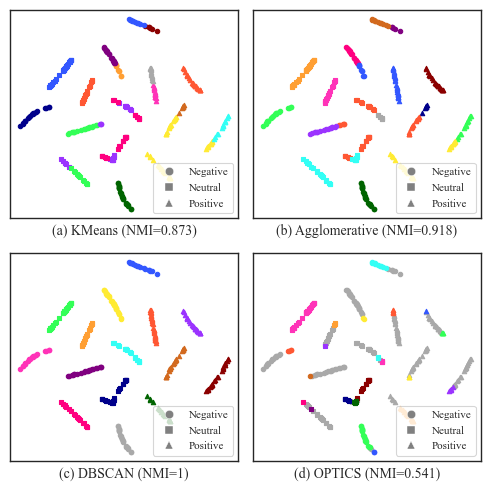

In [285]:

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, init="pca", perplexity = 50, random_state=42)
data_2d = tsne.fit_transform(seed3_sub1_x)

# Create subplots for visualization
from matplotlib.lines import Line2D
# Define clustering methods
clustering_methods = {
    "(a) KMeans (NMI=0.873)": KMeans(n_clusters=18, random_state=42),
    "(b) Agglomerative (NMI=0.918)": AgglomerativeClustering(n_clusters=19),
    "(c) DBSCAN (NMI=1)": DBSCAN(eps=1, min_samples=5),
    "(d) OPTICS (NMI=0.541)": OPTICS(min_samples=18),
}
labels = ["Negative", "Neutral", "Positive"]
sample_size = int(data_2d.shape[0] * 0.1)
np.random.seed(42)  # For reproducibility
sampled_indices = np.random.choice(np.arange(data_2d.shape[0]), sample_size, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
fig.subplots_adjust(wspace=0.15, hspace=0.2)  # Adjust spacing between subplots
# Define 15 distinguishable colors
colors = [
    "#FF5733",  # 红色
    "#33FF57",  # 绿色
    "#3357FF",  # 蓝色
    "#FFEB33",  # 黄色
    "#FF9F33",  # 橙色
    "#9B33FF",  # 紫色
    "#FF33B8",  # 粉色
    "#33FFF5",  # 青色
    "#8B0000",  # 深红色
    "#006400",  # 深绿色
    "#00008B",  # 深蓝色
    "#800080",  # 深紫色
    "#FF0080",  # 橙黄色
    "#D2691E",  # 巧克力色
    "#A9A9A9"   # 深灰色
]

legend_elements = [
    Line2D([0], [0], marker=markers[i], color='w', 
           markerfacecolor='gray', markersize=6, 
           markeredgecolor='white', markeredgewidth=0.3,
           label=labels[i], linestyle='None') 
    for i in range(3)
]

for ax, (name, method) in zip(axes.flatten(), clustering_methods.items()):
    clusters = method.fit_predict(seed3_sub1_x)
    unique_clusters = np.unique(clusters)
    # print(len(unique_clusters))
    sample_x = data_2d[sampled_indices]
    sample_c = clusters[sampled_indices]
    sample_y = seed3_sub1_y[sampled_indices]
    markers = ['o', 's', '^']  # Define markers for different sample_y values
    for cluster in unique_clusters:  
        cluster_indices = np.where(sample_c == cluster)
        for y_value in np.unique(sample_y[cluster_indices]):
            y_indices = np.where(sample_y[cluster_indices] == y_value)
            ax.scatter(
                sample_x[cluster_indices][y_indices, 0], 
                sample_x[cluster_indices][y_indices, 1], 
                facecolors=colors[cluster % len(colors)], 
                # linewidths=0.2,  # Set the edge thickness
                s=10, 
                marker=markers[y_value % len(markers)],
            )
    ax.legend(handles=legend_elements, loc='lower right', fontsize=8)
    ax.set_xlabel(name, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('02_Capture_Intra-individual.png', dpi=300, bbox_inches='tight')

In [ ]:
def calculate_prototypes(tsne_data, clusters):
    prototypes = []
    for cluster_id in np.unique(clusters):
        cluster_points = tsne_data[clusters == cluster_id]
        prototype = cluster_points.mean(axis=0)
        prototypes.append(prototype)
    return np.array(prototypes)
# Map clusters to the most common true label
def map_clusters_to_labels(clusters, true_labels):
    cluster_label_map = {}
    for cluster_id in np.unique(clusters):
        cluster_points_labels = true_labels[clusters == cluster_id]
        most_common_label = Counter(cluster_points_labels).most_common(1)[0][0]
        cluster_label_map[cluster_id] = most_common_label
    return cluster_label_map
def plot_tsne(ax):
    source_sub=3
    sample_ratio=1
    target_sub=1

    model_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\{target_sub}\\many_best.pth"
    # subs = [1, 2, 3] 
    data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
    data, label, Group = SEEDFeatureDataset(data_path).data()
    label += 1
    data = data.reshape(-1, 310)
    tGroup = Group[:, 2] - 1 # 影片的group
    sGroup = Group[:, 1] 

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    for i in np.unique(sGroup):
        data[sGroup==i] = min_max_scaler.fit_transform(data[sGroup == i])
    target = torch.from_numpy(data[sGroup==target_sub]).type(torch.Tensor)
    target_labels = label[sGroup==target_sub]
    target_clusters = tGroup[sGroup==target_sub]
    source = torch.from_numpy(data[sGroup==source_sub]).type(torch.Tensor)
    source_labels = label[sGroup==source_sub] 
    source_clusters = tGroup[sGroup==source_sub]

    model = Base()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))

    source_features = model.feature_extractor(source).detach().cpu().numpy()
    target_features = model.feature_extractor(target).detach().cpu().numpy()


    target_cls = model.predict(target)
    print(np.mean(target_cls == target_labels))
    # Sample a subset of the data for t-SNE

    # 进行tsne
    tsne = TSNE(n_components=2, random_state=3, init="pca", perplexity = 40)

    all_tsne = tsne.fit_transform(np.concatenate((source_features, target_features), axis=0))
    split_index = all_tsne.shape[0] // 2
    source_tsne, target_tsne = all_tsne[:split_index], all_tsne[split_index:]

    target_prototypes = calculate_prototypes(target_tsne, target_clusters)
    source_prototypes = calculate_prototypes(source_tsne, source_clusters)
    target_cluster_label_map = map_clusters_to_labels(target_clusters, target_labels)
    source_cluster_label_map = map_clusters_to_labels(source_clusters, source_labels)

    # 再次采样，为了可视化
    sample_ratio = 1 if 400 / (3394 * sample_ratio) > 1 else 400 / (3394 * sample_ratio)
    # print(sample_ratio)
    np.random.seed(42) 
    sampled_indices = np.random.choice(np.arange(source_features.shape[0]), int(source_features.shape[0] * sample_ratio), replace=False)
    source_tsne = source_tsne[sampled_indices]
    source_labels = source_labels[sampled_indices]
    source_clusters = source_clusters[sampled_indices]
    np.random.seed(42) 
    sampled_indices = np.random.choice(np.arange(target_features.shape[0]), int(target_features.shape[0] * sample_ratio), replace=False)
    target_tsne = target_tsne[sampled_indices]
    target_labels = target_labels[sampled_indices]
    target_cls = target_cls[sampled_indices]
    target_clusters = target_clusters[sampled_indices]

    markers = ['o', 's', '^']  # Different markers for different classes
    colors = ['#299D8F', '#E9C46A', '#D87659']
    # emotions = ['0', '1', '2']
    emotions = ['Negative', 'Neutral', 'Positive']
    for label, marker in enumerate(markers):
        ax.scatter(source_tsne[source_labels == label, 0], source_tsne[source_labels == label, 1],  c=colors[label], label=f'{emotions[label]}', alpha=0.5, s=20, marker="^")
    for label, marker in enumerate(markers):
        ax.scatter(target_tsne[target_labels == label, 0], target_tsne[target_labels == label, 1],  c=colors[label], label=f'{emotions[label]}', alpha=0.5, s=20, marker="o")
        # plt.scatter(target_tsne[target_cls == label, 0], target_tsne[target_cls == label, 1], 
                    # c="red", label=f'Target Class {label}', alpha=0.6, s=10, marker=marker)
    ax.scatter(
        source_prototypes[:, 0], 
        source_prototypes[:, 1], 
        facecolors='none',
        edgecolors=[colors[source_cluster_label_map[cluster_id]] for cluster_id in range(15)], marker='^', 
        s=60, 
    )
    ax.scatter(
        target_prototypes[:, 0], 
        target_prototypes[:, 1], 
        facecolors='none',
        edgecolors=[colors[target_cluster_label_map[cluster_id]] for cluster_id in range(15)], marker='o', 
        s=60, 
    )
    # plt.tight_layout()
def plot_silhouette(ax=None):
    target_sub=1
    model_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\{target_sub}\\many_best.pth"
    data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
    data, label, Group = SEEDFeatureDataset(data_path).data()
    label += 1
    data = data.reshape(-1, 310)
    tGroup = Group[:, 2] - 1 # 影片的group
    sGroup = Group[:, 1] 

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    for i in np.unique(sGroup):
        data[sGroup==i] = min_max_scaler.fit_transform(data[sGroup == i])
    target = torch.from_numpy(data[sGroup==3]).type(torch.Tensor)
    target_labels = label[sGroup==3]
    target_clusters = tGroup[sGroup==3]

    model = Base()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    target_features = model.feature_extractor(target).detach().cpu().numpy()

    pre_sc_cluster = silhouette_score(target.numpy(), target_clusters)
    pre_sc_label = silhouette_score(target.numpy(), target_labels)
    aft_sc_cluster = silhouette_score(target_features, target_clusters)
    aft_sc_label = silhouette_score(target_features, target_labels)
    # print((pre_b_cluster - pre_a_cluster) / np.maximum(pre_b_cluster, pre_a_cluster), silhouette_score(target.numpy(), target_clusters))
    # Perform t-SNE for dimensionality reduction

    values_label = [pre_sc_label, aft_sc_label]
    values_cluster = [pre_sc_cluster, aft_sc_cluster]
    labels = ['Before Train', 'After Train',]

    # 设置柱子宽度
    bar_width = 0.25

    # 设置x轴位置
    index_label = np.arange(len(labels))
    index_cluster = np.arange(len(labels))

    # 绘制训练前的子图
    ax.bar(index_label - bar_width / 2, values_label, bar_width, label='Emotion-wise subdomain', color='#97C8AF')
    ax.bar(index_cluster + bar_width / 2, values_cluster, bar_width, label='Cluster-wise subdomain', color='#96B6D8')
    ax.set_ylabel('Silhouette Score', fontsize=12, fontname='Times New Roman')
    ax.set_xticks(index_label)
    ax.set_xticklabels(labels, fontsize=12, fontname='Times New Roman')

    # ax.legend(fontsize=14, frameon=True, loc='upper left', prop={'family': 'Times New Roman'})

    ax.yaxis.grid(True, linestyle='--', alpha=0.6)

def plot_acc(ax=None):
    target_sub = 1
    source_sub = 3
    model_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\{target_sub}\\many_best.pth"
    # subs = [1, 2, 3] 
    data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
    data, label, Group = SEEDFeatureDataset(data_path).data()
    label += 1
    data = data.reshape(-1, 310)
    tGroup = Group[:, 2] - 1 # 影片的group
    sGroup = Group[:, 1] 

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    for i in np.unique(sGroup):
        data[sGroup==i] = min_max_scaler.fit_transform(data[sGroup == i])
    target = torch.from_numpy(data[sGroup==target_sub]).type(torch.Tensor)
    target_labels = label[sGroup==target_sub]
    target_clusters = tGroup[sGroup==target_sub]
    source = torch.from_numpy(data[sGroup==source_sub]).type(torch.Tensor)
    source_labels = label[sGroup==source_sub] 
    source_clusters = tGroup[sGroup==source_sub]

    model = Base()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))

    source_features = model.feature_extractor(source).detach().cpu().numpy()
    target_features = model.feature_extractor(target).detach().cpu().numpy()

    target_prototypes = calculate_prototypes(target_features, target_labels)
    source_prototypes = calculate_prototypes(source_features, source_labels)
    # similarity_matrix_l = euclidean_distances(target_prototypes, source_prototypes)
    # emotion_sim = cosine_similarity(target_prototypes, source_prototypes)
    emotion_sim = 1 / euclidean_distances(target_prototypes, source_prototypes)
    print(np.mean(model.predict(target) == target_labels), np.mean(np.diag(emotion_sim)))


    # sample_sim = cosine_similarity(target_features, source_features)
    sample_sim = 1 / euclidean_distances(target_features, source_features)
    predicted_target_labels = source_labels[np.argmax(sample_sim, axis=1)]

    sample_output = predicted_target_labels
    print(np.mean(sample_output == target_labels), np.mean(np.max(sample_sim, axis=1)))

    target_prototypes = calculate_prototypes(target_features, target_clusters)
    source_prototypes = calculate_prototypes(source_features, source_clusters)
    source_cluster_label_map = map_clusters_to_labels(source_clusters, source_labels)

    proty_sim = 1 / euclidean_distances(target_prototypes, source_prototypes)
    # proty_sim = cosine_similarity(target_prototypes, source_prototypes)
    # most_similar_indices = np.argmin(proty_sim, axis=1)
    most_similar_indices = np.argmax(proty_sim, axis=1)

    target_cluster_label_map = {cluster_id: source_cluster_label_map[most_similar_indices[cluster_id]] 
                                for cluster_id in range(len(target_prototypes))}

    proto_output = np.array([target_cluster_label_map[cluster_id] for cluster_id in target_clusters])
    print(np.mean(proto_output == target_labels), np.mean(np.max(proty_sim, axis=1)))

    # print(proty_sim)
    results = {
        "model_wise": np.mean(model.predict(target) == target_labels),
        "sample_wise": np.mean(sample_output == target_labels),
        "prototype_wise": np.mean(proto_output == target_labels),
        "prototype_similarity_mean": np.mean(np.max(proty_sim, axis=1)),
        "sample_similarity_mean": np.mean(np.max(sample_sim, axis=1)),
        "emotion_similarity_matrix_mean": np.mean(np.diag(emotion_sim)),
    }


    results_list = [
        results["model_wise"],
        results["sample_wise"],
        results["prototype_wise"],
        results["emotion_similarity_matrix_mean"],
        results["sample_similarity_mean"],
        results["prototype_similarity_mean"],
    ]

    print(np.array(results_list).reshape(2, 3))
    a = np.array(results_list).reshape(2, 3)[0]
    b = np.array(results_list).reshape(2, 3)[1]
    x_labels = ["emotion-wise", "sample-wise",  "cluster-wise"]
    x = np.arange(len(x_labels))

    # Plot pseudo label accuracy (a) on the left y-axis
    ax.plot(x, a, marker='o', color='b', label='Pseudo Label Accuracy')
    ax.set_ylabel('Pseudo Label Accuracy', color='b', fontsize=12)
    ax.set_ylim(0.8, 1)
    ax.set_yticks(np.arange(0.8, 1.05, 0.05))
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=15, fontsize=12)

    # Create a second y-axis for cosine similarity (b)
    ax3 = ax.twinx()
    ax3.plot(x, b, marker='s', color='r', label='Eudeclidean Similarity')
    ax3.set_ylabel('Eudeclidean Similarity', color='r', fontsize=12)
    ax3.set_ylim(0.5, 0.7)
    ax3.set_yticks(np.arange(0.5, 0.75, 0.05))
    ax3.tick_params(axis='y', labelcolor='r')
    # Add legends

    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    return ax3



0.9154390100176782
0.9154390100176782 0.55901927
0.8780200353565115 0.6129317
0.929876252209782 0.5412205
[[0.91543901 0.87802004 0.92987625]
 [0.55901927 0.61293173 0.54122049]]


C:\Users\wlgls\AppData\Local\Temp\ipykernel_45720\4109392574.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("03_subdomain_ana.png", dpi=300, bbox_inches='tight')
d:\miniconda3\envs\wqtorch\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
d:\miniconda3\envs\wqtorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


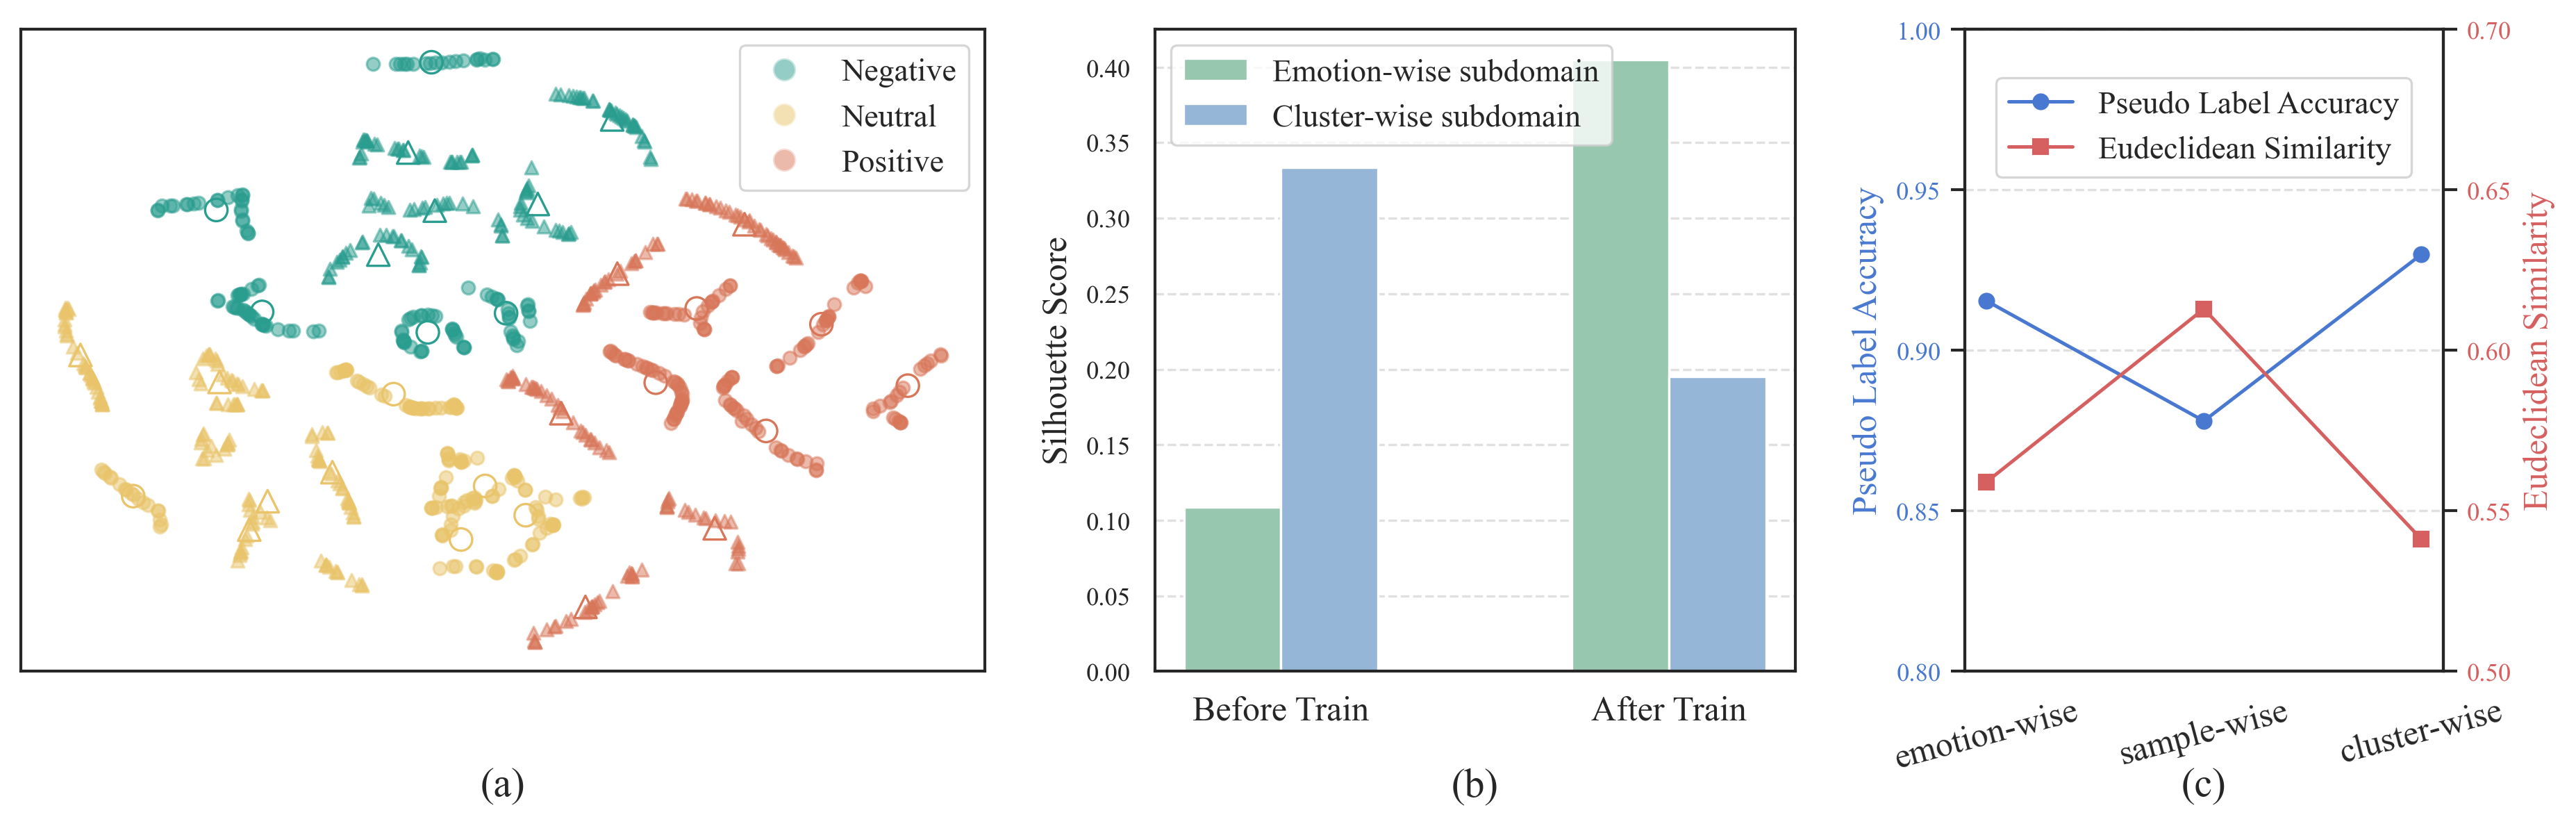

In [267]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 4), dpi=300, tight_layout=True)
gs = GridSpec(1, 15, figure=fig, wspace=0.05)

# 定义第一个子图，占据前 4 列
ax = fig.add_subplot(gs[0, :6])

# 定义第二个子图，占据后 6 列
ax2 = fig.add_subplot(gs[0, 7:11])
ax3 = fig.add_subplot(gs[0, 12:])
plot_tsne(ax=ax)
plot_silhouette(ax=ax2)
ax4 = plot_acc(ax3)
ax.set_xlabel('(a)', fontsize=14, labelpad=20)
ax.xaxis.set_label_coords(0.5, -0.15)
ax2.set_xlabel('(b)', fontsize=14, labelpad=20)
ax2.xaxis.set_label_coords(0.5, -0.15)
ax3.set_xlabel('(c)', fontsize=14, labelpad=20)
ax3.xaxis.set_label_coords(0.5, -0.15)
ax.set_xticks([])
ax.set_yticks([])
# 获取 ax 中所有散点的颜色
emotion = ['Negative', 'Neutral', 'Positive']
handles, labels = ax.get_legend_handles_labels()
unique_colors = {tuple(h.get_facecolor()[0]): c for c, h in zip(emotion, handles)}

# 创建仅基于颜色的图例
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label)
    for color, label in unique_colors.items()
]
ax2.legend(fontsize=11, loc='upper left')
ax.legend(handles=legend_elements, fontsize=11)

lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2[::-1], loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=11)
fig.savefig("03_subdomain_ana.png", dpi=300, bbox_inches='tight')

 ### Result

In [10]:
seed_dirs = [
    r'E:\EEG\logs\0818-MixDBPM\seed3_1\ablation',
    r'E:\EEG\logs\0818-MixDBPM\seed3_2\ablation',
    r'E:\EEG\logs\0818-MixDBPM\seed3_3\ablation'
]

method_acc_dict = {}
for root_dir in seed_dirs:
    # average_last_value = []
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        
        mean_acc_path = os.path.join(folder_path, 'mean_acc.txt')
        if os.path.exists(mean_acc_path):
            with open(mean_acc_path, 'r', encoding='gbk') as f:
                for line in f:
                    match = re.search(r'target:\s*([\d\.]+), best_acc:\s*([\d\.]+)', line)
                    if match:
                        subject_id = int(match.group(1))
                        best_acc = float(match.group(2))
                        # print(f"Subject ID: {subject_id}, Best Acc: {best_acc:.2f}, Time: {time_sec:.2f}s")
                        method_acc_dict.setdefault(folder, []).append(best_acc)
for method, accs in method_acc_dict.items():
    accs = np.array(accs)
    session1_acc = accs[:15]
    session2_acc = accs[15:30] if len(accs) > 15 else np.array([])
    session3_acc = accs[-15:] if len(accs) > 30 else np.array([])
    print(f"{method}: {np.mean(accs):.2f} / {np.std(accs):05.2f}  ({np.mean(session1_acc):.2f}/{np.std(session1_acc):05.2f}, {np.mean(session2_acc):.2f}/{np.std(session2_acc):05.2f}, {np.mean(session3_acc):.2f}/{np.std(session3_acc):05.2f})")


PMEEG: 94.86 / 06.43  (95.42/06.05, 94.66/06.03, 94.51/07.10)
WithOutMixSource: 92.91 / 07.60  (93.68/06.22, 92.51/08.97, 92.54/07.29)
WithOutPLLoss: 85.59 / 06.99  (87.70/04.77, 83.80/08.35, 85.28/06.83)
WithOutPM: 86.32 / 08.41  (88.46/05.66, 83.69/10.00, 86.80/08.28)
WithOutPretrain: 93.09 / 07.86  (92.36/07.16, 93.15/06.83, 93.75/09.30)
WithOutSSTS: 88.80 / 07.69  (91.11/05.06, 85.51/08.61, 89.77/07.78)
WithOutTransferLoss: 83.83 / 09.46  (84.92/04.30, 84.79/08.79, 81.76/12.89)


In [11]:
seed_dirs = [
    r'E:\EEG\logs\0509-MixDBPM\seed4_1\ablation',
    r'E:\EEG\logs\0509-MixDBPM\seed4_2\ablation',
    r'E:\EEG\logs\0509-MixDBPM\seed4_3\ablation'
]

method_acc_dict = {}
for root_dir in seed_dirs:
    # average_last_value = []
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        
        mean_acc_path = os.path.join(folder_path, 'mean_acc.txt')
        if os.path.exists(mean_acc_path):
            with open(mean_acc_path, 'r', encoding='gbk') as f:
                for line in f:
                    match = re.search(r'target:\s*([\d\.]+), best_acc:\s*([\d\.]+)', line)
                    if match:
                        subject_id = int(match.group(1))
                        best_acc = float(match.group(2))
                        # print(f"Subject ID: {subject_id}, Best Acc: {best_acc:.2f}, Time: {time_sec:.2f}s")
                        method_acc_dict.setdefault(folder, []).append(best_acc)
for method, accs in method_acc_dict.items():
    accs = np.array(accs)
    session1_acc = accs[:15]
    session2_acc = accs[15:30] if len(accs) > 15 else np.array([])
    session3_acc = accs[-15:] if len(accs) > 30 else np.array([])
    print(f"{method}: {np.mean(accs):.2f} / {np.std(accs):05.2f}  ({np.mean(session1_acc):.2f}/{np.std(session1_acc):05.2f}, {np.mean(session2_acc):.2f}/{np.std(session2_acc):05.2f}, {np.mean(session3_acc):.2f}/{np.std(session3_acc):05.2f})")


PMEEG: 78.90 / 09.71  (76.39/10.51, 80.54/08.97, 79.76/09.08)
WithOutMixSource: 76.44 / 11.13  (73.81/10.50, 79.95/08.98, 75.57/12.68)
WithOutPLLoss: 78.06 / 10.16  (74.91/09.85, 79.90/10.04, 79.36/09.84)
WithOutPM: 75.27 / 10.67  (72.90/09.32, 77.74/09.38, 75.17/12.44)
WithOutPretrain: 77.48 / 10.33  (75.81/09.94, 79.56/09.21, 77.07/11.36)
WithOutSSTS: 74.21 / 10.82  (71.24/11.34, 75.73/08.78, 75.65/11.51)
WithOutTransferLoss: 70.92 / 11.10  (69.90/10.94, 71.36/09.78, 71.51/12.34)


In [8]:
from sklearn.metrics import f1_score, accuracy_score

In [17]:
from models import PMEEG
for sess in [1, 2, 3]:
    data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
    EEG, Label, Group = SEEDFeatureDataset(data_path, session=sess).data()
    Label += 1
    EEG = EEG.reshape(-1, 310)
    tGroup = Group[:, 2] - 1 # 影片的group
    sGroup = Group[:, 1]
    # Label = np.eye(len(Label), 4)[Label].astype("float32")
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    for i in np.unique(sGroup):
        EEG[sGroup==i] = min_max_scaler.fit_transform(EEG[sGroup == i])

    y_true = []
    y_pred = []
    f1_list = []
    acc_list = []
    model_saved_path = f"E:\\EEG\\logs\\0818-MixDBPM\\seed3_{sess}\\main"
    for target in range(1, 16):
        target_X, target_y = EEG[sGroup == target], Label[sGroup == target]
        # Feature Extract
        model = PMEEG(transfer_loss_type="dann", num_of_class=3).cuda()
        file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
        model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

        with torch.no_grad():
            pm_prob = model.predict(torch.from_numpy(target_X).type(torch.Tensor).cuda())
            # print()
            # print(pm_prob.shape)
            # print(accuracy_score(pm_prob, target_y))
        y_true.append(target_y)
        y_pred.append(pm_prob)
        f1_sub = f1_score(target_y, pm_prob, average='macro')
        acc_sub = accuracy_score(target_y, pm_prob)
        # print(f"Subject {target}: F1 score: {f1_sub:.2f}, Accuracy: {acc_sub:.2f}")
        # 收集每个受试者的分数
        if 'f1_list' not in locals():
            f1_list, acc_list = [], []
        f1_list.append(f1_sub)
        acc_list.append(acc_sub)
    f1_mean = np.mean(f1_list)
    f1_std = np.std(f1_list)
    acc_mean = np.mean(acc_list)
    acc_std = np.std(acc_list)
    print(f"Session {sess}: F1: {f1_mean:.4f} / {f1_std:.4f}, Acc: {acc_mean*100:.2f} / {acc_std*100:.2f}")


Session 1: F1: 0.9531 / 0.0620, Acc: 95.42 / 6.05
Session 2: F1: 0.9452 / 0.0623, Acc: 94.66 / 6.03
Session 3: F1: 0.9438 / 0.0727, Acc: 94.51 / 7.10


In [19]:
from models import PMEEG
for sess in [1, 2, 3]:
    data_path = "E:\\EEG_DataSets\\SEED_IV\\eeg_feature_smooth"
    EEG, Label, Group = SEEDIVFeatureDataset(data_path, session=sess).data()
    # Label += 1
    EEG = EEG.reshape(-1, 310)
    tGroup = Group[:, 2] - 1 # 影片的group
    sGroup = Group[:, 1]
    # Label = np.eye(len(Label), 4)[Label].astype("float32")
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    for i in np.unique(sGroup):
        EEG[sGroup==i] = min_max_scaler.fit_transform(EEG[sGroup == i])

    y_true = []
    y_pred = []
    f1_list = []
    acc_list = []
    model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed4_{sess}\\main"
    for target in range(1, 16):
        target_X, target_y = EEG[sGroup == target], Label[sGroup == target]
        # Feature Extract
        model = PMEEG(transfer_loss_type="dann", num_of_class=4).cuda()
        file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
        model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

        with torch.no_grad():
            pm_prob = model.predict(torch.from_numpy(target_X).type(torch.Tensor).cuda())
            # print()
            # print(pm_prob.shape)
            # print(accuracy_score(pm_prob, target_y))
        y_true.append(target_y)
        y_pred.append(pm_prob)
        f1_sub = f1_score(target_y, pm_prob, average='macro')
        acc_sub = accuracy_score(target_y, pm_prob)
        # print(f"Subject {target}: F1 score: {f1_sub:.2f}, Accuracy: {acc_sub:.2f}")
        # 收集每个受试者的分数
        if 'f1_list' not in locals():
            f1_list, acc_list = [], []
        f1_list.append(f1_sub)
        acc_list.append(acc_sub)
    f1_mean = np.mean(f1_list)
    f1_std = np.std(f1_list)
    acc_mean = np.mean(acc_list)
    acc_std = np.std(acc_list)
    print(f"Session {sess}: F1: {f1_mean:.4f} / {f1_std:.4f}, Acc: {acc_mean*100:.2f} / {acc_std*100:.2f}")


Session 1: F1: 0.7487 / 0.1079, Acc: 76.39 / 10.51
Session 2: F1: 0.7953 / 0.0918, Acc: 80.54 / 8.97
Session 3: F1: 0.7882 / 0.0991, Acc: 79.76 / 9.08


### Exp 1 Confusion matrices.

compared with 
* PR-PL\cite{PR-PL: A novel prototypical representation based pairwise learning framework for emotion recognition using EEG signals}
* Gusa\cite{Gusa: Graph-Based Unsupervised Subdomain Adaptation for Cross-Subject EEG Emotion Recognition}
* GDDN\cite{GDDN: Graph Domain Disentanglement Network for Generalizable EEG Emotion Recognition}

In [2]:
prpl_seed_confusion = np.array([
    [0.92, 0.07, 0.01],
    [0.07, 0.90, 0.03],
    [0.02, 0.02, 0.97]
])
gddn_seediv_confusion = np.array([
    [0.83, 0.05, 0.06, 0.06],
    [0.09, 0.78, 0.05, 0.08],
    [0.10, 0.12, 0.68, 0.09],
    [0.12, 0.13, 0.07, 0.68]
])
gusa_seed_confusion = np.array([
    [0.88, 0.08, 0.05],
    [0.05, 0.94, 0.01],
    [0.03, 0.03, 0.94]
])
gusa_seediv_confusion = np.array([
    [0.81, 0.04, 0.07, 0.08],
    [0.09, 0.74, 0.12, 0.06],
    [0.09, 0.14, 0.68, 0.09],
    [0.09, 0.08, 0.06, 0.76]
])

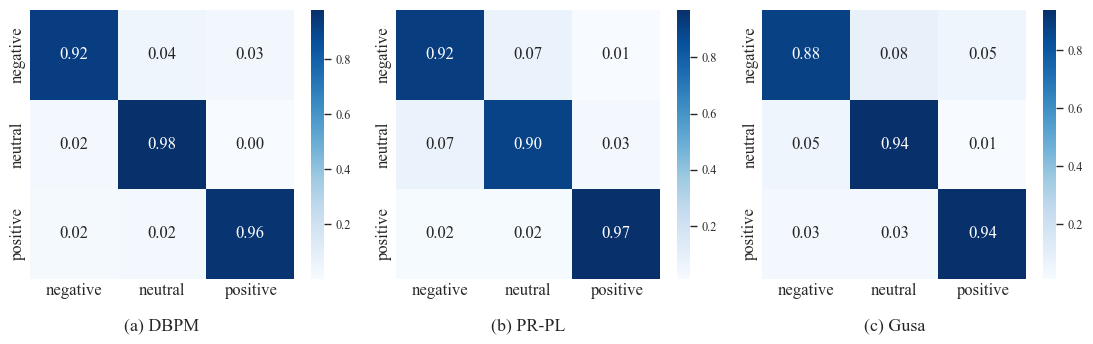

In [3]:

# 求解SEED的混淆矩阵
from models import PMEEG
data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
EEG, Label, Group = SEEDFeatureDataset(data_path, session=1).data()
Label += 1
EEG = EEG.reshape(-1, 310)
tGroup = Group[:, 2] - 1 # 影片的group
sGroup = Group[:, 1]
# Label = np.eye(len(Label), 4)[Label].astype("float32")
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(sGroup):
    EEG[sGroup==i] = min_max_scaler.fit_transform(EEG[sGroup == i])

y_true = []
y_pred = []
model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main"
for target in range(1, 16):
    target_X, target_y = EEG[sGroup == target], Label[sGroup == target]
    # Feature Extract
    model = PMEEG(transfer_loss_type="dann", num_of_class=3).cuda()
    file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
    model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

    with torch.no_grad():
        pm_prob = model.predict(torch.from_numpy(target_X).type(torch.Tensor).cuda())
        # print()
        # print(pm_prob.shape)
        # print(accuracy_score(pm_prob, target_y))
    y_true.append(target_y)
    y_pred.append(pm_prob)
    # break
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
cm = confusion_matrix(y_true, y_pred)
# 将混淆矩阵转换为概率形式
dbpm_seed_confusion_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# 将混淆矩阵转换为概率形式
sns.set_theme(style="white", context="paper", palette="muted", rc={"font.family": "Times New Roman"})
# 使用 seaborn 绘制混淆矩阵
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
fig.tight_layout(pad=0.1)
ax1 = sns.heatmap(dbpm_seed_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'], 
            annot_kws={'size':12}, ax=ax1)
cbar = ax1.collections[0].colorbar
cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线

ax2 = sns.heatmap(prpl_seed_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'], 
            annot_kws={'size':12}, ax=ax2)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线

ax3 = sns.heatmap(gusa_seed_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'], 
            annot_kws={'size':12}, ax=ax3)
cbar = ax3.collections[0].colorbar
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线
ax1.yaxis.set_tick_params(pad=-2)
ax1.xaxis.set_tick_params(pad=-2)
ax2.yaxis.set_tick_params(pad=-2)
ax2.xaxis.set_tick_params(pad=-2)
ax3.yaxis.set_tick_params(pad=-2)
ax3.xaxis.set_tick_params(pad=-2)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
ax3.tick_params(axis='both', labelsize=12)
ax1.set_title('(a) DBPM', fontsize=13, y=-0.22)
ax2.set_title('(b) PR-PL', fontsize=13, y=-0.22)
ax3.set_title('(c) Gusa', fontsize=13, y=-0.22)

plt.savefig('06_cm_for_seed.png', dpi=300, bbox_inches='tight')

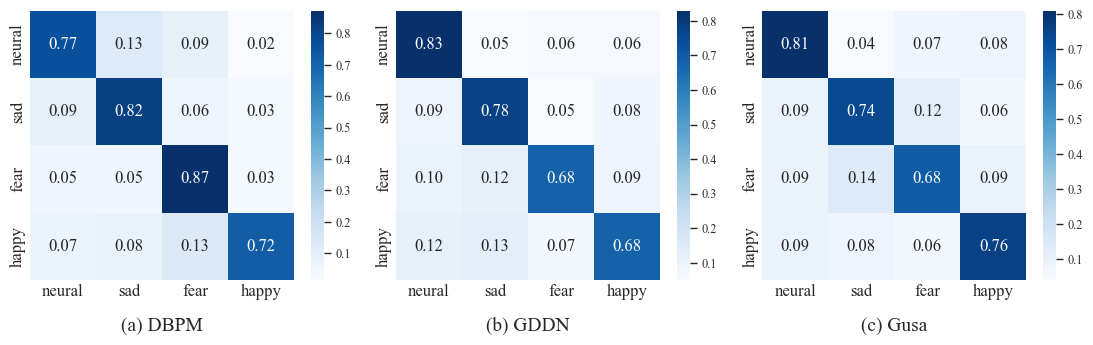

In [4]:
# compute dbpm seediv cm
from models import PMEEG
data_path = "E:\\EEG_DataSets\\SEED_IV\\eeg_feature_smooth"
EEG, Label, Group = SEEDIVFeatureDataset(data_path, session=2).data()
# Label += 1
EEG = EEG.reshape(-1, 310)
tGroup = Group[:, 2] - 1 # 影片的group
sGroup = Group[:, 1]
# Label = np.eye(len(Label), 4)[Label].astype("float32")
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(sGroup):
    EEG[sGroup==i] = min_max_scaler.fit_transform(EEG[sGroup == i])

y_true = []
y_pred = []
model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed4_2\\main"
for target in range(1, 16):
    target_X, target_y = EEG[sGroup == target], Label[sGroup == target]
    # Feature Extract
    model = PMEEG(transfer_loss_type="dann", num_of_class=4).cuda()
    file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
    model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

    with torch.no_grad():
        pm_prob = model.predict(torch.from_numpy(target_X).type(torch.Tensor).cuda())
        # print()
        # print(pm_prob.shape)
        # print(accuracy_score(pm_prob, target_y))
    y_true.append(target_y)
    y_pred.append(pm_prob)
    # break
    
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
cm = confusion_matrix(y_true, y_pred)
# 将混淆矩阵转换为概率形式
dbpm_seediv_confusion_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# 将混淆矩阵转换为概率形式
sns.set_theme(style="white", context="paper", palette="muted", rc={"font.family": "Times New Roman"})
# 使用 seaborn 绘制混淆矩阵
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
fig.tight_layout(pad=0.1)
ax1 = sns.heatmap(dbpm_seediv_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['neural', 'sad', 'fear', 'happy'], 
            yticklabels=['neural', 'sad', 'fear', 'happy'], 
            annot_kws={'size':12}, ax=ax1)
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线

ax2 = sns.heatmap(gddn_seediv_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['neural', 'sad', 'fear', 'happy'], 
            yticklabels=['neural', 'sad', 'fear', 'happy'], 
            annot_kws={'size':12}, ax=ax2)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线

ax3 = sns.heatmap(gusa_seediv_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=['neural', 'sad', 'fear', 'happy'], 
            yticklabels=['neural', 'sad', 'fear', 'happy'], 
            annot_kws={'size':12}, ax=ax3)
cbar = ax3.collections[0].colorbar
cbar.ax.tick_params(which='minor', length=0, width=0)  # 隐藏次要刻度线
ax1.yaxis.set_tick_params(pad=-2)
ax1.xaxis.set_tick_params(pad=-2)
ax2.yaxis.set_tick_params(pad=-2)
ax2.xaxis.set_tick_params(pad=-2)
ax3.yaxis.set_tick_params(pad=-2)
ax3.xaxis.set_tick_params(pad=-2)

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
ax3.tick_params(axis='both', labelsize=12)
ax1.set_title('(a) DBPM', fontsize=14, y=-0.22)
ax2.set_title('(b) GDDN', fontsize=14, y=-0.22)
ax3.set_title('(c) Gusa', fontsize=14, y=-0.22)

plt.savefig('07_cm_for_seediv.png', dpi=300, bbox_inches='tight')

### The Effect of Noisy Level

In [21]:


import os
import re
def get_mean_acc_from_file(file_path):
    results = []
    mean_acc_pattern = re.compile(r"all_best_acc: ([\d.]+)")
    # 遍历目录下的所有文件夹
    for root, dirs, files in os.walk(base_path):
        # print(files)
        for file in files:
            if file == "mean_acc.txt":
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='latin1') as f:          
                    lines = f.readlines()
                    # lines = f.readlines()
                    for line in lines:
                        # print(line)
                        match = mean_acc_pattern.search(line)
                        # print(match)
                        if match:
                            mean_acc = float(match.group(1))
                            results.append((float(os.path.basename(os.path.dirname(file_path))), mean_acc))
    return results
session = 1
base_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_{session}\\Noisy"
sorted_results = sorted(get_mean_acc_from_file(base_path), key=lambda x: x[0])
for eta, acc in sorted_results:
    print(f"eta: {eta}, mean_acc: {acc:.2f}")


eta: 10.0, mean_acc: 91.60
eta: 20.0, mean_acc: 91.24
eta: 30.0, mean_acc: 91.98
eta: 40.0, mean_acc: 92.01
eta: 50.0, mean_acc: 91.96
eta: 60.0, mean_acc: 87.57
eta: 70.0, mean_acc: 81.03


###  Sensitivity Analysis


In [223]:
import os
import re
def get_mean_acc_from_file(file_path):
    results = []
    mean_acc_pattern = re.compile(r"all_best_acc: ([\d.]+)")
    # 遍历目录下的所有文件夹
    for root, dirs, files in os.walk(base_path):
        # print(files)
        for file in files:
            if file == "mean_acc.txt":
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='latin1') as f:          
                    lines = f.readlines()
                    # lines = f.readlines()
                    for line in lines:
                        # print(line)
                        match = mean_acc_pattern.search(line)
                        # print(match)
                        if match:
                            mean_acc = float(match.group(1))
                            results.append((float(os.path.basename(os.path.dirname(file_path))), mean_acc))
    return results

[(1.0, 92.4337), (2.0, 94.343), (4.0, 93.5042), (6.0, 93.6869), (8.0, 94.8046), (10.0, 94.5453), (14.0, 95.4174), (18.0, 94.8399), (22.0, 95.0442), (24.0, 93.9756), (26.0, 95.164), (28.0, 93.569), (32.0, 93.4374), (42.0, 94.6297), (56.0, 94.343)]
[(10.0, 92.308), (20.0, 94.0424), (50.0, 94.3862), (60.0, 94.5001), (70.0, 95.111), (80.0, 94.7594), (90.0, 94.9617), (100.0, 94.2703), (110.0, 95.4174), (120.0, 94.669), (130.0, 94.1289), (140.0, 93.736), (150.0, 94.5531), (170.0, 93.8067), (200.0, 95.0953), (250.0, 95.714), (300.0, 93.6908), (500.0, 94.5472), (1000.0, 94.7378), (1500.0, 95.3801), (2000.0, 92.7362), (2500.0, 93.2528), (3000.0, 92.8678), (5000.0, 92.9896), (6000.0, 90.3555), (7000.0, 91.2218), (8000.0, 89.1436), (9000.0, 92.9307)]


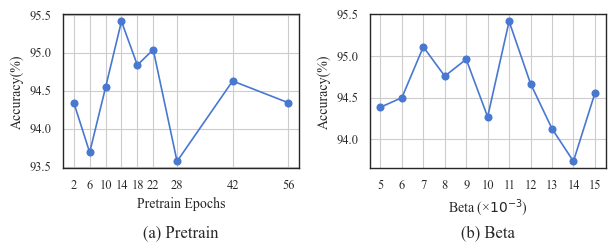

In [239]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 10,                # 全局字体稍大
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

session = 1
# 第一个数据
base_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_{session}\\params\\pre"
sorted_results = sorted(get_mean_acc_from_file(base_path), key=lambda x: x[0])
print(sorted_results)
# Extract x and y values from sorted_results
# 只保留2, 6, 10, 14, 18, 22, 28, 42, 56的数据，并且从小到大排序
keep_keys = [2, 6, 10, 14, 18, 22, 28, 42, 56]
filtered = [(x, y) for x, y in sorted_results if int(x) in keep_keys]
filtered.sort(key=lambda t: t[0])
x_values = [item[0] for item in filtered]
y_values = [item[1] for item in filtered]

# 第二个数据
base_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_{session}\\params\\beta"
sorted_results = sorted(get_mean_acc_from_file(base_path), key=lambda x: x[0])
print(sorted_results)
# Extract x and y values from sorted_results
# 只保留2, 6, 10, 14, 18, 22, 28, 42, 56的数据，并且从小到大排序

filtered = [(x, y) for x, y in sorted_results] #if int(x) in keep_keys]
filtered.sort(key=lambda t: t[0])
filtered = filtered[2:13]
x_beta = [item[0] for item in filtered]
y_beta = [item[1] for item in filtered]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

fig.subplots_adjust(wspace=0.3, hspace=1)
# 第一个图
ax1.plot(x_values, y_values, marker='o', linestyle='-', color='b')
ax1.set_xlabel('Pretrain Epochs', fontsize=10)
ax1.set_ylabel('Accuracy(%)', fontsize=10)
ax1.set_xticks(np.array(x_values, dtype=int))
ax1.set_xticklabels(np.array(x_values, dtype=int))
ax1.grid(True)
ax1.set_title('(a) Pretrain', fontsize=12, y=-0.5)

# 第二个图
ax2.plot(x_beta, y_beta, marker='o', linestyle='-', color='b')
ax2.set_xlabel('Beta (×$10^{-3}$)', fontsize=10)
ax2.set_ylabel('Accuracy(%)', fontsize=10)
ax2.set_xticks(np.array(x_beta, dtype=int))
ax2.set_xticklabels((np.array(x_beta, dtype=int)//10))
ax2.grid(True)
ax2.set_title('(b) Beta', fontsize=12, y=-0.5)

# plt.tight_layout()
# plt.show()
fig.savefig('08_params_ana.png', dpi=300, bbox_inches='tight')


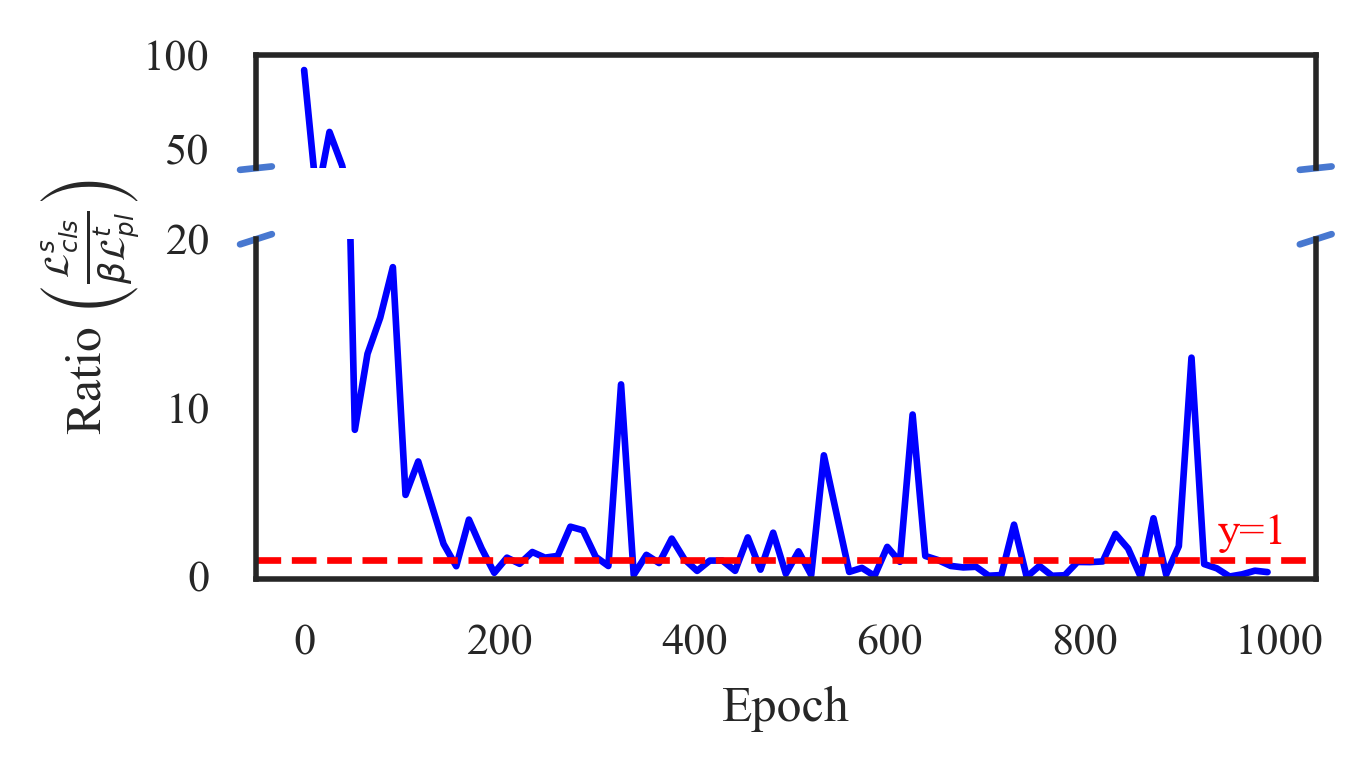

In [6]:
# 你的数据
dbpm_log_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main\\t1.csv"
# 创建图形
loss_s = np.loadtxt(dbpm_log_path, delimiter=',')[:, 0]
loss_t = np.loadtxt(dbpm_log_path, delimiter=',')[:, 2]
ratio = loss_s/(loss_t * 0.011)
x = np.arange(1000)[::13]
data = ratio[x]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3.5,2), 
                               gridspec_kw={'height_ratios': [1, 3]}, dpi=400)
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 9,                # 适用于单栏图的字体大小
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})
# 上图放大高值部分，比如50到100
ax1.plot(x, data, linestyle='-', color='blue')
ax1.set_ylim(40, 100)  
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

# 下图放大低值部分，比如-0.1到20
ax2.plot(x, data, linestyle='-', color='blue')
ax2.set_ylim(-0.1, 20)
ax2.spines['top'].set_visible(False)

# 断轴斜线
d = .015  
kwargs = dict(transform=ax1.transAxes, color='b', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)       
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  
ax2.axhline(y=1, color='red', linestyle='--', label='y=1')
ax2.text(x[-1]+20, 1.4, 'y=1', color='red', va='bottom', ha='right', fontsize=8)
plt.xlabel('Epoch') 
ax2.set_ylabel(r'Ratio $\left(\frac{\mathcal{L}_{cls}^{s}}{\beta\mathcal{L}_{pl}^{t}}\right)$', y=0.8)
# ax2.set_ylabel(r'Ratio $\left(\mathcal{L}_{cls}^{s}/(\beta\mathcal{L}_{cls}^{t})\right)$', y=0.8)
plt.tight_layout()
plt.show()
fig.savefig('09_ratio.png', dpi=300, bbox_inches='tight')


### Exp 6 Stability Analysism

In [240]:

def plot_stability(target, ax):
    dann_log_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\t{target}.csv"
    prpl_log_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\prpl\\t{target}.csv"
    dbpm_log_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main\\t{target}.csv"

    dann = np.loadtxt(dann_log_path, delimiter=',')[:, -1]
    prpl = np.loadtxt(prpl_log_path, delimiter=',')[:, -1]
    # prpl = np.loadtxt(dbpm_log_path, delimiter=',')[:, -4]
    dbpm = np.loadtxt(dbpm_log_path, delimiter=',')[:, -2]
    # Compute the moving average for dbpm with a window size of 14
    # window_size = 14
    # dbpm = np.array([np.mean(dbpm[i:i + window_size]) for i in range(0, len(dbpm), window_size) for _ in range(window_size)])[:len(dbpm)]
    # Pad sequences to ensure they all have a length of 1000
    max_length = 1000
    accs = [dbpm, prpl, dann]

    types = ["DBPM", "PR-PL", "DANN"]
    colors = ["#EF767A", "#456990", "#48C0AA"]
    x = np.arange(0, 1000, 4)
    line_styles = ['-', '--', '-.']
    for i, (type, color, ls) in enumerate(zip(types, colors, line_styles)):
        ax.plot(x, accs[i][x], color=color, label=f"{type}", linestyle=ls)
    # # 隐藏次要刻度

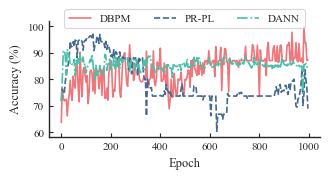

In [244]:
import matplotlib.pyplot as plt

# 设置全局字体
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 9,                # 适用于单栏图的字体大小
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

fig, ax = plt.subplots(figsize=(3.5, 1.5), facecolor="w")

plot_stability(1, ax)

ax.xaxis.set_tick_params(which='minor', width=1, length=0)
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epoch")

# 去除顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置刻度线样式
ax.tick_params(axis='y', which='major', left=True, right=False, direction='in', length=3, width=0.8)
ax.tick_params(axis='x', which='major', bottom=True, top=False, direction='in', length=3, width=0.8)

# 图例放上方居中，3列显示
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.savefig('10_acc_vs_epochs.png', dpi=300, bbox_inches='tight')

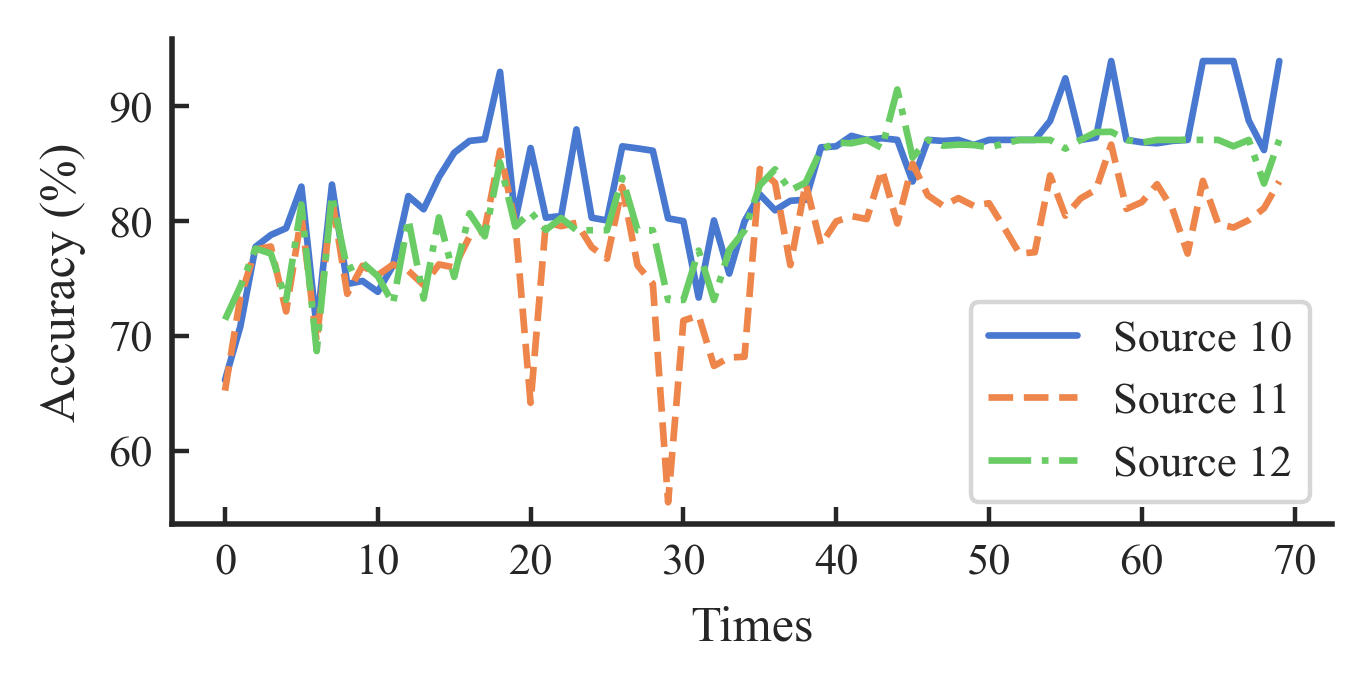

In [248]:
target = 1
dbpm_log_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main\\t{target}.csv"
dbpm = np.loadtxt(dbpm_log_path, delimiter=',')[:, -2]

accs = []
for source in [10, 11, 12]:
    x = np.arange(source + 14, 1000, 14)
    accs.append([source, x, dbpm[x]])

# 设置全局字体和大小（适合IEEE单栏图）
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.8), dpi=400)

line_styles = ['-', '--', '-.']
for i, (source, x, y) in enumerate(accs):
    ax.plot(np.arange(len(y)), y, label=f"Source {source}", linestyle=line_styles[i])

ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Times")

# 去除顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置刻度线
ax.tick_params(axis='y', which='major', left=True, right=False, direction='in', length=3, width=0.8)
ax.tick_params(axis='x', which='major', bottom=True, top=False, direction='in', length=3, width=0.8)

# 图例
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('11_diff_source_acc.png', dpi=300, bbox_inches='tight')
# plt.show()


In [ ]:


import os
import re
def get_mean_acc_from_file(file_path):
    results = []
    mean_acc_pattern = re.compile(r"all_best_acc: ([\d.]+)")
    # 遍历目录下的所有文件夹
    for root, dirs, files in os.walk(base_path):
        # print(files)
        for file in files:
            if file == "mean_acc.txt":
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='latin1') as f:          
                    lines = f.readlines()
                    # lines = f.readlines()
                    for line in lines:
                        # print(line)
                        match = mean_acc_pattern.search(line)
                        # print(match)
                        if match:
                            mean_acc = float(match.group(1))
                            results.append((float(os.path.basename(os.path.dirname(file_path))), mean_acc))
    return results
session = 1
base_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_{session}\\startup"
sorted_results = sorted(get_mean_acc_from_file(base_path), key=lambda x: x[0])

for startup, acc in sorted_results:
    print(f"startup: {startup}, mean_acc: {acc:.2f}")

startup: 1.0, mean_acc: 95.42
startup: 2.0, mean_acc: 94.67
startup: 3.0, mean_acc: 95.46
startup: 4.0, mean_acc: 94.40
startup: 5.0, mean_acc: 94.65
startup: 6.0, mean_acc: 94.51
startup: 7.0, mean_acc: 94.34
startup: 8.0, mean_acc: 94.66
startup: 9.0, mean_acc: 95.30
startup: 10.0, mean_acc: 94.44
startup: 11.0, mean_acc: 94.48
startup: 12.0, mean_acc: 95.49
startup: 13.0, mean_acc: 94.21
startup: 14.0, mean_acc: 94.35


### pesudo ana

In [37]:
from sklearn.metrics import silhouette_score, accuracy_score
data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
EEG, Label, Group = SEEDFeatureDataset(data_path, session=1).data()
Label += 1
EEG = EEG.reshape(-1, 310)
tGroup = Group[:, 2] - 1 # 影片的group
sGroup = Group[:, 1]
Label = np.eye(len(Label), 3)[Label].astype("float32")
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(sGroup):
    EEG[sGroup==i] = min_max_scaler.fit_transform(EEG[sGroup == i])

y_true = []
y_pred = []
p_pred = []
s1_pred = []
s2_pred = []
d_pred = []
model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main"
for target in range(1, 16):
    model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main"
    # 读取每个目标的csv文件，找到倒数第二列最大值所在的行
    csv_path = os.path.join(model_saved_path, f"t{target}.csv")
    if os.path.exists(csv_path):
        data = np.loadtxt(csv_path, delimiter=',')
        if data.ndim == 1:
            data = data.reshape(1, -1)
        max_idx = np.argmax(data[:, -2]) -1
        # 可用：max_row = data[max_idx]
        # print(f"Target {target}: max at row {max_idx}, current source {max_idx % 14},  value={data[max_idx, -2]}")

    source_lists = list(range(1, 16))
    source_lists.remove(target)
    source_idx = source_lists[max_idx % 14]
    source_x, source_y = EEG[sGroup == source_idx], Label[sGroup == source_idx]
    # print(source_x.shape, source_y.shape)
    source_c = DBSCAN(eps=1, min_samples=5).fit(source_x).labels_

    target_x, target_y = EEG[sGroup == target], Label[sGroup == target]
    target_c = DBSCAN(eps=1, min_samples=5).fit(target_x).labels_
    source_x = torch.from_numpy(source_x).type(torch.Tensor).cuda()
    source_y = torch.from_numpy(source_y).type(torch.LongTensor).cuda()
    source_c = torch.from_numpy(source_c).type(torch.LongTensor)

    target_x = torch.from_numpy(target_x).type(torch.Tensor).cuda()
    target_c = torch.from_numpy(target_c).type(torch.LongTensor)
    # print(target_c, source_c)
    # Feature Extract
    model = PMEEG(transfer_loss_type="dann", num_of_class=3).cuda()
    file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
    model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))
    model.source_cluster_label = torch.zeros(15).type(torch.long)
    model.target_cluster_label = torch.zeros(15).type(torch.long)
    model.source_cluster_P = torch.randn(15, 64) # 目标域的原型表征
    # model.reset_source_cluster_label(source_y, source_c)
    # model.update_source_cluster_P(source_x, source_c)
    model.epoch_end_hook(source_x, target_x, source_y, source_c, target_c)

    # target_cluster_preds = torch.tensor([model.target_cluster_label[int(cluster.item())] for cluster in target_cluster], dtype=torch.long).to(target_clf.device)

    with torch.no_grad():
        pm_prob = model.predict(target_x)
        # pesduo_prob = model.predict2(target_x, target_c).cpu().numpy()
        target_cluster_preds = np.array([model.target_cluster_label[int(cluster.item())] for cluster in target_c])
        # print()
        # print(pm_prob.shape)
        # print(pesduo_prob.shape, target_y.shape)
        # print(accuracy_score(target_cluster_preds, np.argmax(target_y, axis=1)))
    p_pred.append(target_cluster_preds)
    y_true.append(target_y)
    y_pred.append(pm_prob)

    model_saved_path = r"E:\EEG\logs\0818-MixDBPM\PesudoLabel"
    csv_path = os.path.join(model_saved_path, f"t{target}.csv")
    if os.path.exists(csv_path):
        data = np.loadtxt(csv_path, delimiter=',')
        if data.ndim == 1:
            data = data.reshape(1, -1)
        max_idx = np.argmax(data[:, -2]) -1
        # 可用：max_row = data[max_idx]
        # print(f"Target {target}: max at row {max_idx}, current source {max_idx % 14},  value={data[max_idx, -2]}")

    source_lists = list(range(1, 16))
    source_lists.remove(target)
    source_idx = source_lists[max_idx % 14]
    source_x, source_y = EEG[sGroup == source_idx], Label[sGroup == source_idx]
    source_x = torch.from_numpy(source_x).type(torch.Tensor).cuda()
    source_y = torch.from_numpy(source_y).type(torch.LongTensor).cuda()

    model = PMEEG(transfer_loss_type="dann", num_of_class=3).cuda()
    file_path = os.path.join(model_saved_path, str(target),  "many_best.pth")
    model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))
    with torch.no_grad():
        s2_pred.append(model.predict(target_x))
        target_cluster_preds = model.predict_by_sample_wise(model.feature_extractor(source_x), source_y, model.feature_extractor(target_x))
    s1_pred.append(target_cluster_preds.cpu().numpy())

    model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\{target}"
    wmodel = Base(transfer_loss_type="dann").cuda()
    file_path = os.path.join(model_saved_path, "many_best.pth")
    wmodel.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))
    with torch.no_grad():
        d_pred.append(wmodel.predict(target_x))
    # break
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
p_pred = np.concatenate(p_pred)
s1_pred = np.concatenate(s1_pred)
s2_pred = np.concatenate(s2_pred)
d_pred = np.concatenate(d_pred)
print(accuracy_score(y_true.argmax(axis=1), y_pred), accuracy_score(y_true.argmax(axis=1), p_pred))
print(accuracy_score(y_true.argmax(axis=1), s2_pred), accuracy_score(y_true.argmax(axis=1), s1_pred.argmax(axis=1)))
print(accuracy_score(y_true.argmax(axis=1), d_pred))

0.9541740326065606 0.9537222549597328
0.8845413474759379 0.8281280691416225
0.8825967393439403


### Cross Dataset

In [33]:
import os
import pandas as pd

csv_dir = r"E:\EEG\logs\0818-MixDBPM\crossdataset\3to4"
results = []
for fname in os.listdir(csv_dir):
    if fname.endswith('.csv'):
        fpath = os.path.join(csv_dir, fname)
        data = np.loadtxt(fpath, delimiter=',')
        value = data[-1, -1]
        results.append((fname, value))
print(results)
if results:
    values = [v for _, v in results]
    mean_value = sum(values) / len(values)
    print("平均值:", mean_value)
else:
    print("results 为空")

[('t1.csv', np.float64(60.517)), ('t10.csv', np.float64(67.0975)), ('t11.csv', np.float64(73.208)), ('t12.csv', np.float64(55.4642)), ('t13.csv', np.float64(58.1669)), ('t14.csv', np.float64(59.342)), ('t15.csv', np.float64(73.208)), ('t16.csv', np.float64(54.9279)), ('t17.csv', np.float64(51.9231)), ('t18.csv', np.float64(67.0673)), ('t19.csv', np.float64(60.6971)), ('t2.csv', np.float64(57.4618)), ('t20.csv', np.float64(70.5529)), ('t21.csv', np.float64(73.7981)), ('t22.csv', np.float64(71.0337)), ('t23.csv', np.float64(56.7308)), ('t24.csv', np.float64(75.0)), ('t25.csv', np.float64(80.4087)), ('t26.csv', np.float64(61.2981)), ('t27.csv', np.float64(54.6875)), ('t28.csv', np.float64(49.399)), ('t29.csv', np.float64(58.5337)), ('t3.csv', np.float64(69.0952)), ('t30.csv', np.float64(83.774)), ('t31.csv', np.float64(56.691)), ('t32.csv', np.float64(77.8589)), ('t33.csv', np.float64(58.2725)), ('t34.csv', np.float64(80.5353)), ('t35.csv', np.float64(56.5693)), ('t36.csv', np.float64(87.

In [34]:
import os
import pandas as pd

csv_dir = r"E:\EEG\logs\0818-MixDBPM\crossdataset\4to3"
results = []
for fname in os.listdir(csv_dir):
    if fname.endswith('.csv'):
        fpath = os.path.join(csv_dir, fname)
        data = np.loadtxt(fpath, delimiter=',')
        value = data[-1, -1]
        results.append((fname, value))
print(results)
if results:
    values = [v for _, v in results]
    mean_value = sum(values) / len(values)
    print("平均值:", mean_value)
else:
    print("results 为空")

[('t1.csv', np.float64(81.6146)), ('t10.csv', np.float64(69.6229)), ('t11.csv', np.float64(58.6034)), ('t12.csv', np.float64(90.1002)), ('t13.csv', np.float64(60.7543)), ('t14.csv', np.float64(68.5916)), ('t15.csv', np.float64(79.4932)), ('t16.csv', np.float64(74.1308)), ('t17.csv', np.float64(63.1703)), ('t18.csv', np.float64(68.0318)), ('t19.csv', np.float64(72.1862)), ('t2.csv', np.float64(68.4443)), ('t20.csv', np.float64(71.1255)), ('t21.csv', np.float64(73.571)), ('t22.csv', np.float64(83.5592)), ('t23.csv', np.float64(81.3789)), ('t24.csv', np.float64(82.8521)), ('t25.csv', np.float64(70.8309)), ('t26.csv', np.float64(61.4909)), ('t27.csv', np.float64(67.7077)), ('t28.csv', np.float64(62.0507)), ('t29.csv', np.float64(56.8061)), ('t3.csv', np.float64(50.1768)), ('t30.csv', np.float64(82.9699)), ('t31.csv', np.float64(71.1255)), ('t32.csv', np.float64(52.6517)), ('t33.csv', np.float64(72.2451)), ('t34.csv', np.float64(59.1043)), ('t35.csv', np.float64(65.7042)), ('t36.csv', np.fl

In [30]:


def t_sne(x, y=None):
    tsne = TSNE(n_components=2, init="pca", perplexity = 50, random_state=42)
    x_tsne = tsne.fit_transform(x)
    return x_tsne, y
sub_t = 5
sub_s = 1
data_path = "E:\\EEG_DataSets\\SEED\\ExtractedFeatures\\"
seed3, seed3_l, seed3_g = SEEDFeatureDataset(data_path, subjects=[sub_t, sub_s]).data()
seed3_l += 1
seed3 = seed3.reshape(-1, 310)
seed3_tg = seed3_g[:, 2] - 1
seed3_sg = seed3_g[:, 1]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in np.unique(seed3_sg):
    seed3[seed3_sg==i] = min_max_scaler.fit_transform(seed3[seed3_sg == i])

seed3_cluster = DBSCAN(eps=1, min_samples=5).fit(seed3).labels_

sampled_indices_all = []
for sg in np.unique(seed3_sg):
    idx = np.where(seed3_sg == sg)[0]
    np.random.seed(42)
    sample_size = int(len(idx) * 0.2)
    sampled_idx = np.random.choice(idx, sample_size, replace=False)
    sampled_indices_all.append(sampled_idx)
sampled_indices_all = np.concatenate(sampled_indices_all)
seed3_sample = seed3[sampled_indices_all]
seed3_l_sample = seed3_l[sampled_indices_all]
seed3_sg_sample = seed3_sg[sampled_indices_all]
seed3_cluster_sample = seed3_cluster[sampled_indices_all]

model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\seed3_1\\main\\{sub_t}"
model = PMEEG(transfer_loss_type="dann").cuda()
file_path = os.path.join(model_saved_path, "many_best.pth")
model.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

model_saved_path = f"E:\\EEG\\logs\\0509-MixDBPM\\Other\\Base\\{sub_t}"
wmodel = Base(transfer_loss_type="dann").cuda()
file_path = os.path.join(model_saved_path, "many_best.pth")
wmodel.load_state_dict(torch.load(file_path,  map_location=torch.device('cuda:0')))

model.eval()
with torch.no_grad():
    feat_samples = model.feature_extractor(torch.from_numpy(seed3_sample).type(torch.Tensor).cuda()).cpu().numpy()
    w_feat_samples = wmodel.feature_extractor(torch.from_numpy(seed3_sample).type(torch.Tensor).cuda()).cpu().numpy()
f_tsne, f_y = t_sne(feat_samples, seed3_l_sample)
w_tsne, w_y = t_sne(w_feat_samples, seed3_l_sample)
x_tsne, x_y = t_sne(seed3_sample, seed3_l_sample)

from collections import Counter

# Calculate prototypes for each cluster
def calculate_prototypes(tsne_data, clusters):
    prototypes = []
    for cluster_id in np.unique(clusters):
        cluster_points = tsne_data[clusters == cluster_id]
        prototype = cluster_points.mean(axis=0)
        prototypes.append(prototype)
    return np.array(prototypes)
# Map clusters to the most common true label
def map_clusters_to_labels(clusters, true_labels):
    cluster_label_map = {}
    for cluster_id in np.unique(clusters):
        cluster_points_labels = true_labels[clusters == cluster_id]
        most_common_label = Counter(cluster_points_labels).most_common(1)[0][0]
        cluster_label_map[cluster_id] = most_common_label
    return cluster_label_map

proto_f = calculate_prototypes(f_tsne, seed3_cluster_sample)
cluster_label_map = map_clusters_to_labels(seed3_cluster_sample, seed3_l_sample)
w_proto_f = calculate_prototypes(w_tsne, seed3_cluster_sample)
x_proto_f = calculate_prototypes(x_tsne, seed3_cluster_sample)


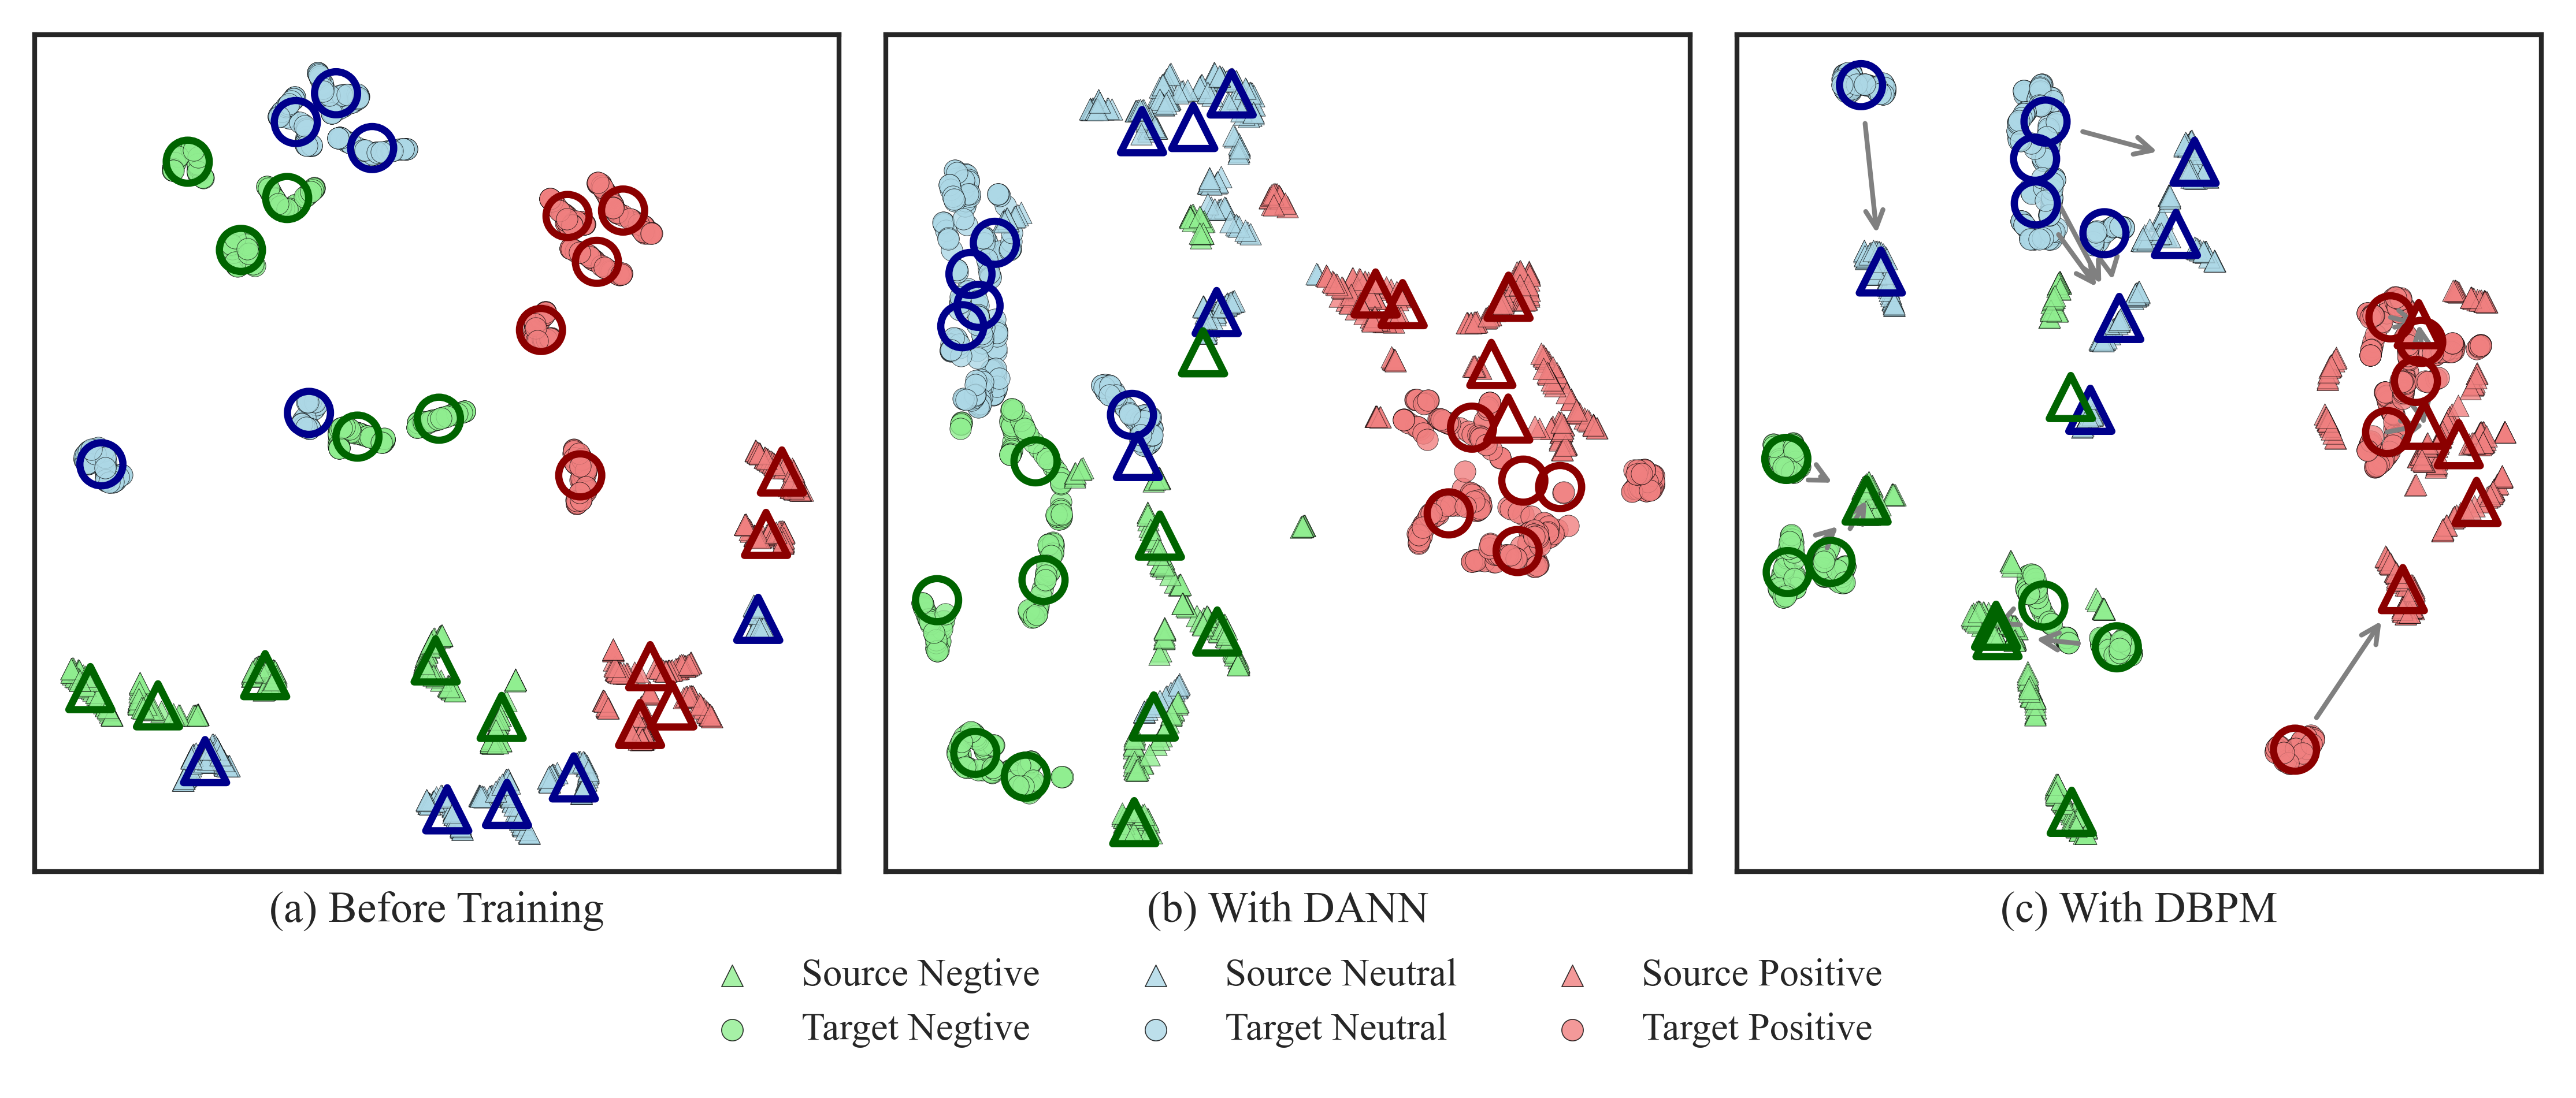

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# --- 建议修改的参数 ---
# 适合双栏的尺寸
fig_width = 7.5
fig_height = fig_width * (1.2/3)  # 保持比例，但给图例留出空间
dpi_setting = 600

fig, axes = plt.subplots(1, 3, figsize=(fig_width, fig_height), dpi=dpi_setting)

# 颜色和尺寸
light_colors = ['lightgreen', 'lightblue', 'lightcoral']  # 样本点用浅色
dark_colors = ['darkgreen', 'darkblue', 'darkred']        # 原型点用深色
prototype_size = 80
sample_size = 20

# 定义一个辅助函数来绘制子图，避免重复代码
def plot_tsne_panel(ax, tsne_data, proto_data, cluster_sample, cluster_label_map, is_dbpm=False):
    # 绘制样本点
    for cluster_id in range(30):
        indices = cluster_sample == cluster_id
        color_idx = cluster_label_map[cluster_id] % 3
        domain_marker = '^' if cluster_id >= 15 else 'o'
        
        ax.scatter(
            tsne_data[indices, 0],
            tsne_data[indices, 1],
            c=light_colors[color_idx],
            marker=domain_marker,
            s=sample_size,
            alpha=0.8,
            edgecolors='black',
            linewidth=0.1
        )

    # 绘制原型点
    for cluster_id in range(30):
        color_idx = cluster_label_map[cluster_id] % 3
        domain_marker = '^' if cluster_id >= 15 else 'o'
        
        ax.scatter(
            proto_data[cluster_id, 0],
            proto_data[cluster_id, 1],
            c="none",
            marker=domain_marker,
            s=prototype_size,
            edgecolors=dark_colors[color_idx],
            linewidth=1.5,
            zorder=10
        )
    
    # 绘制DBPM的箭头
    if is_dbpm:
        source_protos = proto_data[15:, :]
        target_protos = proto_data[:15, :]
        
        for i, target_proto in enumerate(target_protos):
            distances = np.sqrt(np.sum((source_protos - target_proto) ** 2, axis=1))
            nearest_source_idx = np.argmin(distances)
            
            start_x, start_y = target_proto[0], target_proto[1]
            end_x, end_y = source_protos[nearest_source_idx][0], source_protos[nearest_source_idx][1]
            
            ax.annotate('', 
                        xy=(end_x, end_y), 
                        xytext=(start_x, start_y), 
                        arrowprops=dict(
                            arrowstyle='->', 
                            color='gray', 
                            alpha=1,
                            linewidth=1,
                            shrinkA=8, 
                            shrinkB=8
                        )
                    )
    
    # 清除坐标轴
    ax.set_xticks([])
    ax.set_yticks([])

# 假设您已加载了所有数据，例如 x_tsne, w_tsne, f_tsne, x_proto_f, w_proto_f, proto_f
plot_tsne_panel(axes[0], x_tsne, x_proto_f, seed3_cluster_sample, cluster_label_map)
plot_tsne_panel(axes[1], w_tsne, w_proto_f, seed3_cluster_sample, cluster_label_map)
plot_tsne_panel(axes[2], f_tsne, proto_f, seed3_cluster_sample, cluster_label_map, is_dbpm=True)

# 设置子图标题
axes[0].set_xlabel('(a) Before Training', fontsize=9)
axes[1].set_xlabel('(b) With DANN', fontsize=9)
axes[2].set_xlabel('(c) With DBPM', fontsize=9)

# 创建图例元素
legend_elements = [
    axes[2].scatter([], [], c=light_colors[0], marker='^', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Source Negtive'),
    axes[2].scatter([], [], c=light_colors[0], marker='o', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Target Negtive'),
    axes[2].scatter([], [], c=light_colors[1], marker='^', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Source Neutral'),
    axes[2].scatter([], [], c=light_colors[1], marker='o', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Target Neutral'),
    axes[2].scatter([], [], c=light_colors[2], marker='^', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Source Positive'),
    axes[2].scatter([], [], c=light_colors[2], marker='o', s=20, alpha=0.8, 
                           edgecolors='black', linewidth=0.2, label='Target Positive'),
]

# 在一个空区域添加图例
fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.1),
           ncol=3, 
           fontsize=8, 
           frameon=False) 

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('img\\12_feature_visualization.png', dpi=300, bbox_inches='tight')